In [1]:
import torch
import torch.nn.functional as F
import copy
import numpy as np
from BNNBench.backbones.unet import define_G
from BNNBench.backbones.resnet import ResNet101
from BNNBench.backbones.vgg import VGG
from BNNBench.data.paired_data import get_loader_with_dir

In [8]:
def get_model(f=None):
    m = define_G(1, 1, 64, "unet_256", norm="instance", use_dropout=False)
    if f is not None:
        m.load_state_dict(torch.load(f))
    return m

def get_cls_model(f):
    checkpoint = torch.load(f)
    model_cls = lambda: VGG("VGG16", 100)
    net = model_cls().cuda()
    net = torch.nn.DataParallel(net)
    net.load_state_dict(checkpoint['net'])
    return net

def inner_prod(init_G, G_ref, G):
    cross = 0.0
    L1 = 0.0
    L2 = 0.0
    for w_init, w_ref, w in zip(init_G.parameters(), G_ref.parameters(), G.parameters()):
        d1 = (w_ref - w_init)
        d2 = (w - w_init)
        cross += (d1 * d2).sum()
        L1 += (d1 * d1).sum()
        L2 += (d2 * d2).sum()
    return cross / torch.sqrt(L1 * L2)

def L2_dist(G_mid, G):
    cross = 0.0
    total = 0.0
    for w_mid, w in zip(G_mid.parameters(), G.parameters()):
        d = w_mid - w
        cross += (d * d).sum()
        total += d.numel()
    return torch.sqrt(cross / total)

def test_err(loader, G):
    G.eval()
    loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            pred = G(x)
            loss += F.l1_loss(pred, y).item()
    return loss / len(loader)

In [4]:
import matplotlib.pyplot as plt

init_G = get_cls_model("../checkpoint/vgg16_cifar100/ckpt_0")
G_first = get_cls_model("../checkpoint/vgg16_cifar100/local0_0_7.pth")

cosine_dist = []
euclidian_dist = []
for i in range(1, 10):
    G = get_cls_model(f"../checkpoint/vgg16/local0_0_{i}.pth")
    cosine_dist.append(inner_prod(init_G, G_first, G).item())
    euclidian_dist.append(L2_dist(init_G, G).item())

plt.subplot(121)
plt.plot(cosine_dist)
plt.xlabel("Epoch")
plt.ylabel("Cosine distance")

plt.subplot(122)
plt.plot(euclidian_dist)
plt.xlabel("Epoch")
plt.ylabel("Euclidian distance")
plt.show()

In [12]:
def loss_surface(loader, G, G1, G2, x, y):
    """Compute the loss for model G(x, y) = (1 - x - y) * G + x * G1 + y * G2"""
    G_out = copy.deepcopy(G)
    for w_out, w1, w2 in zip(G_out.parameters(), G1.parameters(), G2.parameters()):
        w_out.data.mul_(1 - x - y)
        w_out.data.add_(x * w1.data + y * w2.data)
    return test_err(loader, G_out)
    
G_center = get_cls_model("../checkpoint/vgg16_cifar100/ckpt_0.pth")
Gs = [get_cls_model(f"../checkpoint/vgg16_cifar100/ckpt_{i}.pth") for i in range(1, 6)]
#G2 = get_cls_model("../checkpoint/vgg16_cifar100/local0_1_7.pth")
#G2 = get_model(None)
for i in range(5):
    for j in range(i+1, 6):
        #print(i, j, inner_prod(G_center, Gs[i], Gs[j]))
        pass

Gs.append(G_center)
for i in range(5):
    for j in range(i+1, 6):
        print(i, j, L2_dist(Gs[i], Gs[j]))

0 1 tensor(0.1519, device='cuda:0', grad_fn=<SqrtBackward>)
0 2 tensor(0.1523, device='cuda:0', grad_fn=<SqrtBackward>)
0 3 tensor(0.1525, device='cuda:0', grad_fn=<SqrtBackward>)
0 4 tensor(0.1524, device='cuda:0', grad_fn=<SqrtBackward>)
0 5 tensor(0.1524, device='cuda:0', grad_fn=<SqrtBackward>)
1 2 tensor(0.1519, device='cuda:0', grad_fn=<SqrtBackward>)
1 3 tensor(0.1520, device='cuda:0', grad_fn=<SqrtBackward>)
1 4 tensor(0.1519, device='cuda:0', grad_fn=<SqrtBackward>)
1 5 tensor(0.1519, device='cuda:0', grad_fn=<SqrtBackward>)
2 3 tensor(0.1524, device='cuda:0', grad_fn=<SqrtBackward>)
2 4 tensor(0.1522, device='cuda:0', grad_fn=<SqrtBackward>)
2 5 tensor(0.1524, device='cuda:0', grad_fn=<SqrtBackward>)
3 4 tensor(0.1525, device='cuda:0', grad_fn=<SqrtBackward>)
3 5 tensor(0.1525, device='cuda:0', grad_fn=<SqrtBackward>)
4 5 tensor(0.1523, device='cuda:0', grad_fn=<SqrtBackward>)


In [12]:
loader = get_loader_with_dir("../datasets/cd105/A/train/", "../datasets/cd105/B/train/", 1024, 30, True)

../datasets/cd105/A/train/112.png
../datasets/cd105/A/train/446.png
../datasets/cd105/A/train/116.png
../datasets/cd105/A/train/580.png
../datasets/cd105/A/train/284.png
../datasets/cd105/A/train/218.png
../datasets/cd105/A/train/80.png
../datasets/cd105/A/train/109.png
../datasets/cd105/A/train/466.png
../datasets/cd105/A/train/88.png
../datasets/cd105/A/train/301.png
../datasets/cd105/A/train/422.png
../datasets/cd105/A/train/203.png
../datasets/cd105/A/train/382.png
../datasets/cd105/A/train/120.png
../datasets/cd105/A/train/538.png
../datasets/cd105/A/train/126.png
../datasets/cd105/A/train/419.png
../datasets/cd105/A/train/436.png
../datasets/cd105/A/train/108.png
../datasets/cd105/A/train/96.png
../datasets/cd105/A/train/12.png
../datasets/cd105/A/train/449.png
../datasets/cd105/A/train/138.png
../datasets/cd105/A/train/504.png
../datasets/cd105/A/train/213.png
../datasets/cd105/A/train/314.png
../datasets/cd105/A/train/30.png
../datasets/cd105/A/train/305.png
../datasets/cd105/A

In [55]:
xs = np.arange(-10, 10, 1)
ys = np.arange(-10, 10, 1)
losses = np.zeros((len(xs), len(ys)))
for ix, x in enumerate(xs):
    for iy, y in enumerate(ys):
        loss_xy = loss_surface(loader, G_center, G1, G2, x, y)
        losses[ix, iy] = loss_xy

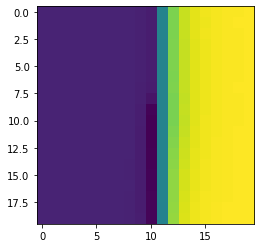

In [56]:
import matplotlib.pyplot as plt

plt.imshow(losses)

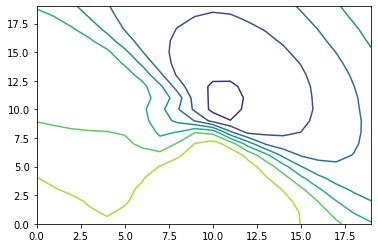

In [7]:
plt.contour(losses)

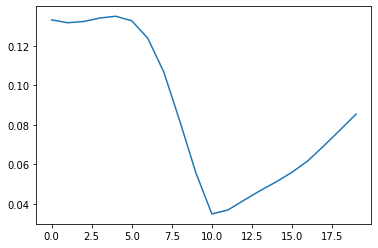

In [10]:
plt.plot(losses[10, :])

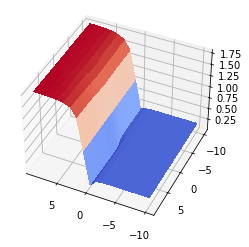

In [58]:
from matplotlib import cm

x_mesh, y_mesh = np.meshgrid(xs, ys)
z = losses
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x_mesh, y_mesh, losses, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(40, 115)

In [13]:
%timeit loss_surface(loader, G_center, G1, G2, 1, 1)

6.58 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
z[10, 19] - z[10, 10]

0.05046074680591884

In [25]:
xs

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9])